In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import kaleido
kaleido.get_chrome_sync()

PosixPath('/usr/local/lib/python3.12/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome')

In [26]:
plt.style.use('dark_background')
sns.set_palette("husl")


In [71]:
fg_df = pd.read_csv('/content/fear_greed_index.csv')

hs_df = pd.read_csv('/content/historical_data.csv')
print(f"\nLoaded Fear & Greed Index: {fg_df.shape}")
print(f"Loaded Historical Data: {hs_df.shape}")




Loaded Fear & Greed Index: (2644, 4)
Loaded Historical Data: (211224, 16)


In [77]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

fg_df['date'] = pd.to_datetime(fg_df['date'],dayfirst=True)
fg_df['value'] = pd.to_numeric(fg_df['value'],
                               errors='coerce')
fg_df = fg_df.dropna(subset=['date', 'value', 'classification'])

print(f"\nFear & Greed Index Info:")
print(f" Date Range: {fg_df['date'].min()} to {fg_df['date'].max()}")
print(f" Sentiment Distribution:\n{fg_df['classification'].value_counts()}")
fg_df.to_csv("csv_files/prepfg_data.csv", index=False)

hs_df['Timestamp IST'] = pd.to_datetime(hs_df['Timestamp IST'],dayfirst=True)
hs_df['date'] = hs_df['Timestamp IST'].dt.date
hs_df['Closed PnL'] = pd.to_numeric(hs_df['Closed PnL'], errors='coerce')
hs_df['Size USD'] = pd.to_numeric(hs_df['Size USD'], errors='coerce')
hs_df['Fee'] = pd.to_numeric(hs_df['Fee'], errors='coerce')
hs_df = hs_df.dropna(subset=['Closed PnL'])

print(f"\nTrader Data Info:")
print(f" Date Range: {hs_df['Timestamp IST'].min()} to {hs_df['Timestamp IST'].max()}")
print(f" Total Trades: {len(hs_df):,}")
print(f" Unique Accounts: {hs_df['Account'].nunique():,}")
print(f" Coins Traded: {hs_df['Coin'].nunique()}")
hs_df.to_csv("csv_files/prephs_data.csv", index=False)



DATA PREPROCESSING

Fear & Greed Index Info:
 Date Range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
 Sentiment Distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Trader Data Info:
 Date Range: 2023-05-01 01:06:00 to 2025-05-01 12:13:00
 Total Trades: 211,224
 Unique Accounts: 32
 Coins Traded: 246


In [78]:
print("\n" + "="*80)
print("MERGING SENTIMENT WITH TRADES")
print("="*80)

if not isinstance(fg_df['date'].iloc[0], pd.Timestamp):
  fg_df['date'] = pd.to_datetime(fg_df['date'])
fg_df['date'] = fg_df['date'].dt.date
sentiment_lookup = fg_df.set_index('date')[['value', 'classification']].to_dict('index')

hs_df['sentiment_value'] = hs_df['date'].map(lambda x: sentiment_lookup.get(x, {}).get('value'))
hs_df['sentiment_class'] = hs_df['date'].map(lambda x: sentiment_lookup.get(x, {}).get('classification'))

merged_df = hs_df.dropna(subset=['sentiment_class']).copy()
print(f"\n Merged Dataset: {len(merged_df):,} trades with sentiment data")
print(f"  Coverage: {len(merged_df)/len(hs_df)*100:.1f}% of total trades")
merged_df.to_csv("csv_files/merged_data.csv", index=False)



MERGING SENTIMENT WITH TRADES

 Merged Dataset: 211,218 trades with sentiment data
  Coverage: 100.0% of total trades


In [80]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

merged_df['is_profitable'] = (merged_df['Closed PnL'] > 0).astype(int)
merged_df['hour'] = merged_df['Timestamp IST'].dt.hour
merged_df['day_of_week'] = merged_df['Timestamp IST'].dt.dayofweek
merged_df['net_pnl'] = merged_df['Closed PnL'] - merged_df['Fee']

merged_df['sentiment_simple'] = merged_df['sentiment_class'].apply(
    lambda x: 'Fear' if 'Fear' in str(x) else 'Greed' if 'Greed' in str(x) else 'Neutral'
)

print(" Added features: is_profitable, hour, day_of_week, net_pnl, sentiment_simple")
merged_df.to_csv("csv_files/engineered_data.csv", index=False)


FEATURE ENGINEERING
 Added features: is_profitable, hour, day_of_week, net_pnl, sentiment_simple


In [81]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

total_pnl = merged_df['Closed PnL'].sum()
total_volume = merged_df['Size USD'].sum()
win_rate = (merged_df['Closed PnL'] > 0).mean() * 100

print(f"\n Overall Trading Statistics:")
print(f" Total PnL: ${total_pnl:,.2f}")
print(f" Total Volume: ${total_volume:,.2f}")
print(f"  Win Rate: {win_rate:.2f}%")
print(f" Avg Trade Size: ${merged_df['Size USD'].mean():,.2f}")
print(f" Avg PnL per Trade: ${merged_df['Closed PnL'].mean():.2f}")

print("\n Performance by Sentiment Class:")
sentiment_stats = merged_df.groupby('sentiment_class').agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'mean',
    'is_profitable': 'mean'
}).round(2)
sentiment_stats.columns = ['Total_PnL', 'Avg_PnL', 'Trades', 'Avg_Size', 'Win_Rate']
sentiment_stats['Win_Rate'] = sentiment_stats['Win_Rate'] * 100
print(sentiment_stats)
sentiment_stats.to_csv("csv_files/sentiment_stats.csv")


EXPLORATORY DATA ANALYSIS

 Overall Trading Statistics:
 Total PnL: $10,254,486.95
 Total Volume: $1,191,098,773.60
  Win Rate: 41.12%
 Avg Trade Size: $5,639.19
 Avg PnL per Trade: $48.55

 Performance by Sentiment Class:
                  Total_PnL  Avg_PnL  Trades  Avg_Size  Win_Rate
sentiment_class                                                 
Extreme Fear      739110.25    34.54   21400   5349.73      37.0
Extreme Greed    2715171.31    67.89   39992   3112.25      46.0
Fear             3357155.44    54.29   61837   7816.11      42.0
Greed            2150129.27    42.74   50303   5736.88      38.0
Neutral          1292920.68    34.31   37686   4782.73      40.0



VISUALISATIONS


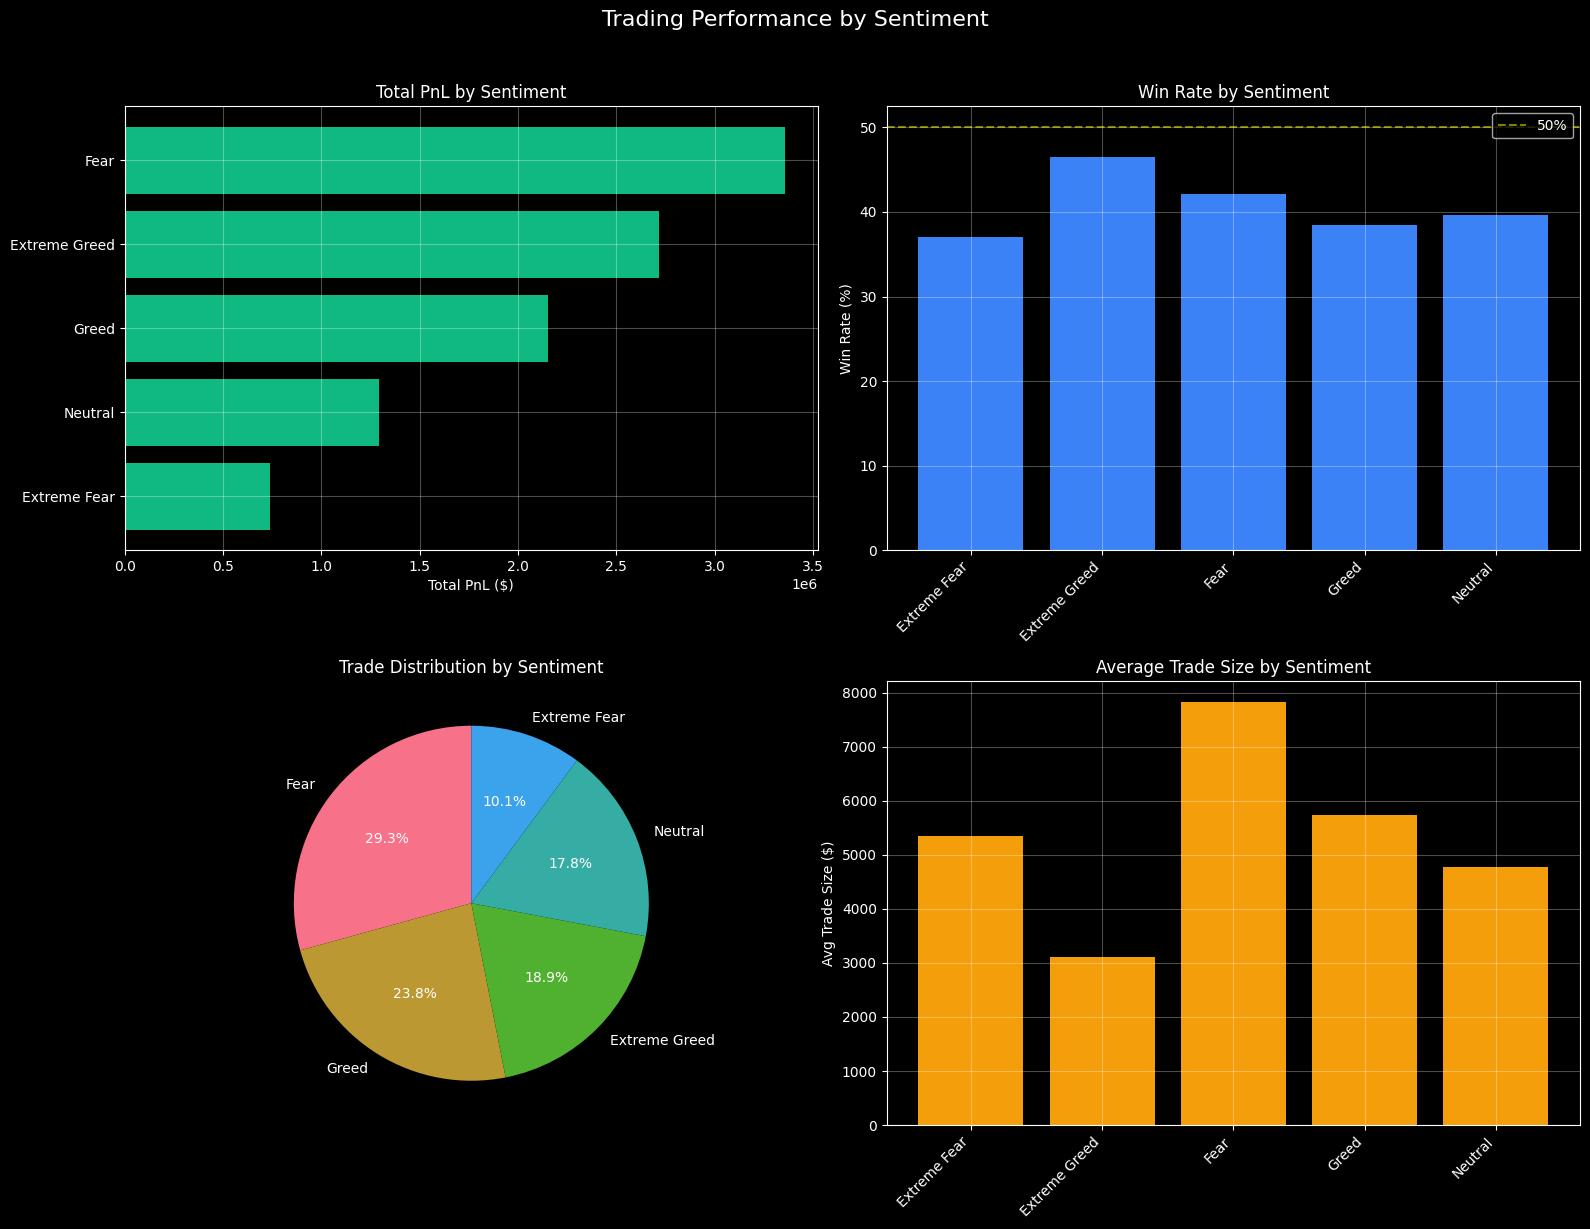

<Figure size 640x480 with 0 Axes>

In [85]:
print("\n" + "="*80)
print("VISUALISATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Trading Performance by Sentiment', fontsize=16, y=1.02)

sentiment_pnl = merged_df.groupby('sentiment_class')['Closed PnL'].sum().sort_values()
axes[0, 0].barh(sentiment_pnl.index, sentiment_pnl.values, color=['#ef4444' if x < 0 else '#10b981' for x in sentiment_pnl.values])
axes[0, 0].set_xlabel('Total PnL ($)')
axes[0, 0].set_title('Total PnL by Sentiment')
axes[0, 0].grid(alpha=0.3)

win_rate_data = merged_df.groupby('sentiment_class')['is_profitable'].mean() * 100
axes[0, 1].bar(range(len(win_rate_data)), win_rate_data.values, color='#3b82f6')
axes[0, 1].set_xticks(range(len(win_rate_data)))
axes[0, 1].set_xticklabels(win_rate_data.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Win Rate (%)')
axes[0, 1].set_title('Win Rate by Sentiment')
axes[0, 1].axhline(y=50, color='yellow', linestyle='--', alpha=0.5, label='50%')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

trade_counts = merged_df['sentiment_class'].value_counts()
axes[1, 0].pie(trade_counts.values, labels=trade_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Trade Distribution by Sentiment')

avg_size = merged_df.groupby('sentiment_class')['Size USD'].mean()
axes[1, 1].bar(range(len(avg_size)), avg_size.values, color='#f59e0b')
axes[1, 1].set_xticks(range(len(avg_size)))
axes[1, 1].set_xticklabels(avg_size.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Avg Trade Size ($)')
axes[1, 1].set_title('Average Trade Size by Sentiment')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("outputs/Trading Performance by Sentiment.png")

In [96]:
daily_stats = merged_df.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'sentiment_value': 'first',
    'Account': 'count'
}).reset_index()
daily_stats.columns = ['date', 'daily_pnl', 'daily_volume', 'sentiment', 'trade_count']
daily_stats['date'] = pd.to_datetime(daily_stats['date'])
daily_stats = daily_stats.sort_values('date')

daily_stats['pnl_7d_ma'] = daily_stats['daily_pnl'].rolling(7).mean()
daily_stats['pnl_30d_ma'] = daily_stats['daily_pnl'].rolling(30).mean()

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=('Daily PnL', 'Sentiment Index', 'Trading Volume'),
    vertical_spacing=0.08,
    row_heights=[0.4, 0.3, 0.3]
)


fig.add_trace(go.Scatter(
    x=daily_stats['date'], y=daily_stats['daily_pnl'],
    mode='lines', name='Daily PnL', line=dict(color='#3b82f6', width=1)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=daily_stats['date'], y=daily_stats['pnl_7d_ma'],
    mode='lines', name='7-Day MA', line=dict(color='#10b981', width=2)
), row=1, col=1)


fig.add_trace(go.Scatter(
    x=daily_stats['date'], y=daily_stats['sentiment'],
    mode='lines', name='Sentiment', line=dict(color='#f59e0b', width=2),
    fill='tozeroy', fillcolor='rgba(245, 158, 11, 0.2)'
), row=2, col=1)


fig.add_trace(go.Bar(
    x=daily_stats['date'], y=daily_stats['daily_volume'],
    name='Volume', marker_color='#8b5cf6'
), row=3, col=1)

fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="PnL ($)", row=1, col=1)
fig.update_yaxes(title_text="Sentiment", row=2, col=1)
fig.update_yaxes(title_text="Volume ($)", row=3, col=1)

fig.update_layout(
    height=900,
    title_text="Time Series Analysis: PnL, Sentiment & Volume",
    showlegend=True,
    hovermode='x unified'
)

fig.show()
kaleido.write_fig_sync(fig, path="outputs/Time Series Analysis.png")


CORRELATION ANALYSIS


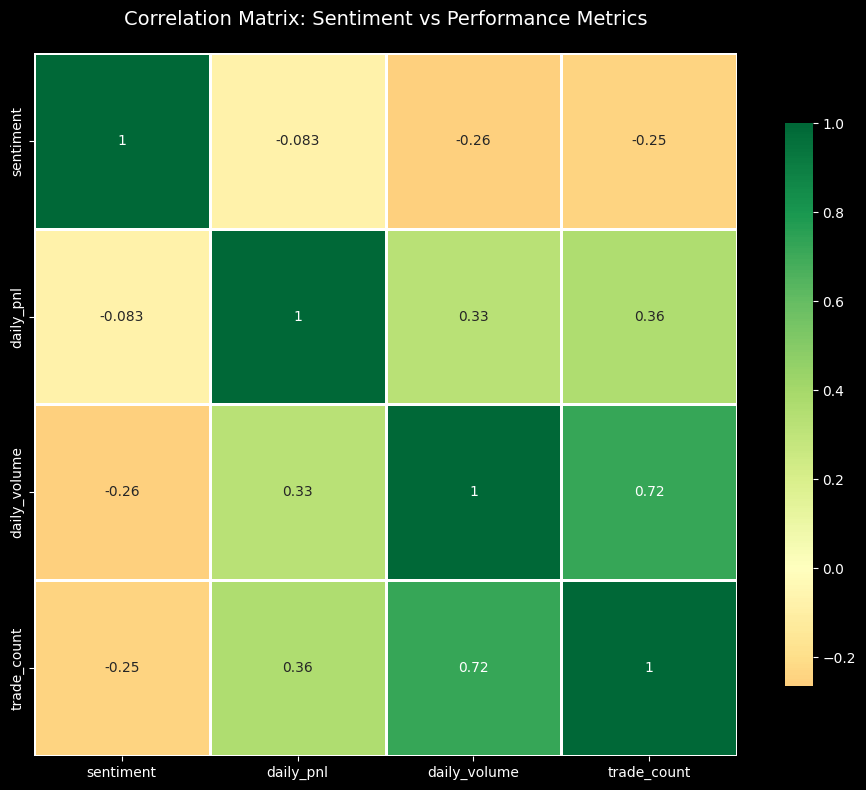


 Key Correlations with Sentiment:
 Sentiment vs Daily PnL: -0.083
 Sentiment vs Volume: -0.264
 Sentiment vs Trade Count: -0.245


<Figure size 640x480 with 0 Axes>

In [97]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation = daily_stats[['sentiment', 'daily_pnl', 'daily_volume', 'trade_count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Sentiment vs Performance Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n Key Correlations with Sentiment:")
print(f" Sentiment vs Daily PnL: {correlation.loc['sentiment', 'daily_pnl']:.3f}")
print(f" Sentiment vs Volume: {correlation.loc['sentiment', 'daily_volume']:.3f}")
print(f" Sentiment vs Trade Count: {correlation.loc['sentiment', 'trade_count']:.3f}")
plt.savefig("outputs/Correlation Matrix.png")

In [82]:
print("\n" + "="*80)
print("TRADER SEGMENTATION ANALYSIS")
print("="*80)

trader_sentiment = merged_df.groupby(['Account', 'sentiment_simple']).agg({
    'Closed PnL': ['sum', 'mean', 'count'],
    'Size USD': 'mean',
    'is_profitable': 'mean'
}).reset_index()

trader_sentiment.columns = ['Account', 'Sentiment', 'Total_PnL', 'Avg_PnL', 'Trades', 'Avg_Size', 'Win_Rate']

print("\n Top 10 Traders in FEAR periods:")
top_fear = trader_sentiment[trader_sentiment['Sentiment'] == 'Fear'].nlargest(10, 'Total_PnL')
print(top_fear[['Account', 'Total_PnL', 'Trades', 'Win_Rate']].to_string(index=False))
top_fear.to_csv("csv_files/top_fear.csv", index=False)

print("\n Top 10 Traders in GREED periods:")
top_greed = trader_sentiment[trader_sentiment['Sentiment'] == 'Greed'].nlargest(10, 'Total_PnL')
print(top_greed[['Account', 'Total_PnL', 'Trades', 'Win_Rate']].to_string(index=False))
top_greed.to_csv("csv_files/top_greed.csv", index=False)


TRADER SEGMENTATION ANALYSIS

 Top 10 Traders in FEAR periods:
                                   Account    Total_PnL  Trades  Win_Rate
0x083384f897ee0f19899168e3b1bec365f52a9012 1.238143e+06    1878  0.518104
0xbaaaf6571ab7d571043ff1e313a9609a10637864 8.827904e+05   16917  0.466809
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4 4.634781e+05    2382  0.367758
0x72c6a4624e1dffa724e6d00d64ceae698af892a0 3.434149e+05     652  0.569018
0x513b8629fe877bb581bf244e326a047b249c4ff1 2.960444e+05    6327  0.366841
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3 2.745103e+05    1568  0.437500
0x8170715b3b381dffb7062c0298972d4727a0a63b 1.640062e+05    1904  0.295168
0x420ab45e0bd8863569a5efbb9c05d91f40624641 1.091094e+05     159  0.238994
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23 1.027101e+05    3744  0.323985
0xbee1707d6b44d4d52bfe19e41f8a828645437aab 8.675289e+04   17980  0.386930

 Top 10 Traders in GREED periods:
                                   Account    Total_PnL  Trades  Win_Rate
0xb1231a4a2dd

In [64]:
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

fear_pnl = merged_df[merged_df['sentiment_simple'] == 'Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['sentiment_simple'] == 'Greed']['Closed PnL']

t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl)

print("\n T-Test: PnL in Fear vs Greed")
print(f" Mean PnL (Fear): ${fear_pnl.mean():.2f}")
print(f" Mean PnL (Greed): ${greed_pnl.mean():.2f}")
print(f" T-statistic: {t_stat:.4f}")
print(f" P-value: {p_value:.6f}")
print(f" Significant: {'YES' if p_value < 0.05 else 'NO'} (alpha = 0.05)")

contingency_table = pd.crosstab(merged_df['sentiment_simple'], merged_df['is_profitable'])
chi2, p_value_chi, dof, expected = stats.chi2_contingency(contingency_table)

print("\n Chi-Square Test: Win Rate Distribution")
print(f" Chi-square statistic: {chi2:.4f}")
print(f" P-value: {p_value_chi:.6f}")
print(f" Significant: {'YES' if p_value_chi < 0.05 else 'NO'} (alpha = 0.05)")



STATISTICAL SIGNIFICANCE TESTS

 T-Test: PnL in Fear vs Greed
 Mean PnL (Fear): $49.21
 Mean PnL (Greed): $53.88
 T-statistic: -0.9881
 P-value: 0.323117
 Significant: NO (alpha = 0.05)

 Chi-Square Test: Win Rate Distribution
 Chi-square statistic: 66.1901
 P-value: 0.000000
 Significant: YES (alpha = 0.05)



ADVANCED INSIGHTS

 Extreme Sentiment Analysis:
  Extreme Fear - Avg PnL: $34.54, Win Rate: 37.1%
  Extreme Greed - Avg PnL: $67.89, Win Rate: 46.5%


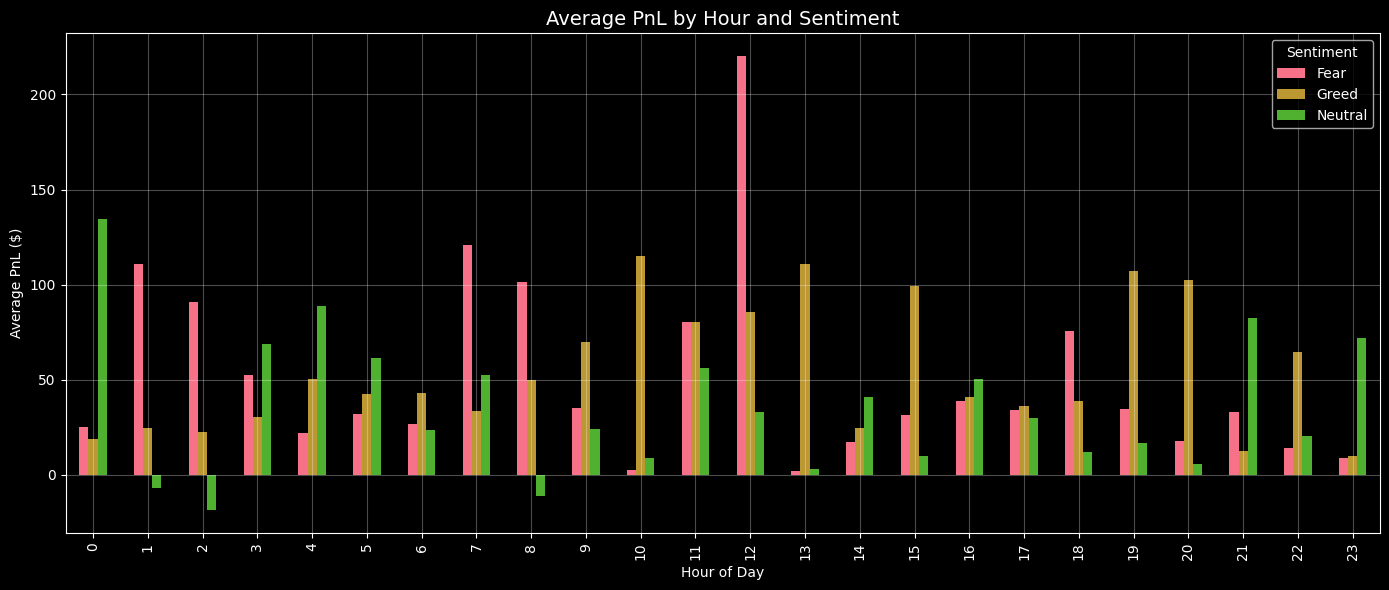

<Figure size 640x480 with 0 Axes>

In [98]:
print("\n" + "="*80)
print("ADVANCED INSIGHTS")
print("="*80)

extreme_fear = merged_df[merged_df['sentiment_class'] == 'Extreme Fear']
extreme_greed = merged_df[merged_df['sentiment_class'] == 'Extreme Greed']

print("\n Extreme Sentiment Analysis:")
print(f"  Extreme Fear - Avg PnL: ${extreme_fear['Closed PnL'].mean():.2f}, Win Rate: {(extreme_fear['is_profitable'].mean()*100):.1f}%")
print(f"  Extreme Greed - Avg PnL: ${extreme_greed['Closed PnL'].mean():.2f}, Win Rate: {(extreme_greed['is_profitable'].mean()*100):.1f}%")

hourly_sentiment = merged_df.groupby(['hour', 'sentiment_simple'])['Closed PnL'].mean().unstack()

plt.figure(figsize=(14, 6))
hourly_sentiment.plot(kind='bar', ax=plt.gca())
plt.title('Average PnL by Hour and Sentiment', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average PnL ($)')
plt.legend(title='Sentiment')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("outputs/Average PnL by Hour and Sentiment.png")
coin_sentiment = merged_df.groupby(['Coin', 'sentiment_simple']).agg({
    'Closed PnL': 'sum',
    'Account': 'count'
}).reset_index()
coin_sentiment.columns = ['Coin', 'Sentiment', 'Total_PnL', 'Trades']

top_coins = coin_sentiment.groupby('Coin')['Trades'].sum().nlargest(5).index
coin_comparison = coin_sentiment[coin_sentiment['Coin'].isin(top_coins)]

fig = px.bar(coin_comparison, x='Coin', y='Total_PnL', color='Sentiment',
             title='Top 5 Coins: PnL by Sentiment', barmode='group')
fig.show()
kaleido.write_fig_sync(fig, path="outputs/Top 5 Coins: PnL by Sentiment.png")

In [84]:
print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)

fear_trades = merged_df[merged_df['sentiment_simple'] == 'Fear']
greed_trades = merged_df[merged_df['sentiment_simple'] == 'Greed']

findings = {
    'Total Trades Analyzed': len(merged_df),
    'Date Range': f"{merged_df['date'].min()} to {merged_df['date'].max()}",
    'Overall Win Rate': f"{(merged_df['is_profitable'].mean()*100):.2f}%",
    'Fear Period Win Rate': f"{(fear_trades['is_profitable'].mean()*100):.2f}%",
    'Greed Period Win Rate': f"{(greed_trades['is_profitable'].mean()*100):.2f}%",
    'Best Performing Sentiment': sentiment_stats['Total_PnL'].idxmax(),
    'Most Traded Sentiment': merged_df['sentiment_class'].value_counts().idxmax(),
    'Avg Trade Size (Fear)': f"${fear_trades['Size USD'].mean():.2f}",
    'Avg Trade Size (Greed)': f"${greed_trades['Size USD'].mean():.2f}",
}

print("\n Summary Statistics:")
for key, value in findings.items():
    print(f"  {key}: {value}")

print("\n ACTIONABLE INSIGHTS:")
if fear_pnl.mean() > greed_pnl.mean():
    print(" Traders are MORE profitable during FEAR periods - consider counter-trend strategies")
else:
    print(" Traders are MORE profitable during GREED periods - momentum strategies may work better")

if fear_trades['Size USD'].mean() < greed_trades['Size USD'].mean():
    print(" Position sizes are SMALLER during fear - traders show risk aversion")
else:
    print(" Position sizes are LARGER during fear - contrarian traders may be overconfident")

findings_df = pd.DataFrame(list(findings.items()), columns=['Metric', 'Value'])
findings_df.to_csv("csv_files/insights.csv", index=False)


KEY FINDINGS SUMMARY

 Summary Statistics:
  Total Trades Analyzed: 211218
  Date Range: 2023-05-01 to 2025-05-01
  Overall Win Rate: 41.12%
  Fear Period Win Rate: 40.79%
  Greed Period Win Rate: 42.03%
  Best Performing Sentiment: Fear
  Most Traded Sentiment: Fear
  Avg Trade Size (Fear): $7182.01
  Avg Trade Size (Greed): $4574.42

 ACTIONABLE INSIGHTS:
 Traders are MORE profitable during GREED periods - momentum strategies may work better
 Position sizes are LARGER during fear - contrarian traders may be overconfident
